# NL below SL
This notebook shows the results of the analysis of the Netherlands below sea-level analysis.
This accompanies the google earth engine script. For each tile it is computed how many 0.5x0.5m pixels a histogram is computed. This analysis combines all the grid tiles into one histogram. 

In [8]:
# read files
import pathlib
import re
import itertools

# computations
import numpy as np

# tables
import pandas as pd
import geojson
import geopandas

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# All data is stored here. An extract from the results of the Google Earth Engine. Takes a few days to compute. 
data_dir = pathlib.Path('~/src/sealevel/data/deltares/nl-below-sl/').expanduser()

In [10]:
# loop over all tiles, combine into 1 set of features
features = []
paths = data_dir.glob('*.geojson')
for path in paths:
    with path.open() as f:
        data = geojson.load(f)
        for feature in data['features']:
            feature['properties']['filename'] = path.name
        features.extend(data.features)

In [11]:
features = geojson.FeatureCollection(features=features)

In [12]:
# store in 1 table
gdf = geopandas.GeoDataFrame.from_features(features)
gdf

,geometry,count,hist,maskedFrac,nGte0,nLt0,filename
0,"POLYGON ((5.84654 53.02871, 5.94654 53.02871, ...",{'elevation': 251181574},"{'elevation': [[-3.39, 17.0], [-3.380000000000...",{'elevation': 0.8420256523803018},{'elevation': 10743178.7372549},{'elevation': 240439648.52156848},05m-noclip-26-23ee_export.geojson
1,"POLYGON ((5.24654 52.62871, 5.34654 52.62871, ...",{'elevation': 45998502},"{'elevation': [[-10.65, 3.0], [-10.64, 6.0], [...",{'elevation': 0.15281616845991558},{'elevation': 6576408.65882353},{'elevation': 39423366.01960784},05m-noclip-20-19ee_export.geojson
2,"POLYGON ((5.24654 53.42871, 5.34654 53.42871, ...",{'elevation': 0},{'elevation': None},{'elevation': 0.0},{'elevation': 0.0},{'elevation': 0.0},05m-noclip-20-27ee_export.geojson
3,"POLYGON ((4.14654 53.02871, 4.24654 53.02871, ...",{'elevation': 0},{'elevation': None},{'elevation': 0.0},{'elevation': 0.0},{'elevation': 0.0},05m-noclip-9-23ee_export.geojson
4,"POLYGON ((6.04654 52.02871, 6.14654 52.02871, ...",{'elevation': 273436752},"{'elevation': [[5.63, 1.0], [5.64, 0.0], [5.64...",{'elevation': 0.8962594530088386},{'elevation': 273437292.309804},{'elevation': 0.0},05m-noclip-28-13ee_export.geojson
...,...,...,...,...,...,...,...
1109,"POLYGON ((6.04654 52.82871, 6.14654 52.82871, ...",{'elevation': 288722476},"{'elevation': [[-2.17, 1.0], [-2.16, 4.0], [-2...",{'elevation': 0.9634812293312885},{'elevation': 270487715.05098045},{'elevation': 18235813.180392154},05m-noclip-28-21ee_export.geojson
1110,"POLYGON ((5.64654 53.12871, 5.74654 53.12871, ...",{'elevation': 283583248},"{'elevation': [[-4.0, 4.0], [-3.99, 7.0], [-3....",{'elevation': 0.9528099900382695},{'elevation': 219860966.9137254},{'elevation': 63720932.400000006},05m-noclip-24-24ee_export.geojson
1111,"POLYGON ((5.44654 52.72871, 5.54654 52.72871, ...",{'elevation': 0},{'elevation': None},{'elevation': 0.0},{'elevation': 0.0},{'elevation': 0.0},05m-noclip-22-20ee_export.geojson
1112,"POLYGON ((3.74654 52.12871, 3.84654 52.12871, ...",{'elevation': 0},{'elevation': None},{'elevation': 0.0},{'elevation': 0.0},{'elevation': 0.0},05m-noclip-5-14ee_export.geojson


In [15]:
# read all files
filename_pattern = re.compile(r'05m-noclip-(?P<i>\d+)-(?P<j>\d+)ee_export.geojson')
gdf['file_info'] = gdf.filename.apply(lambda x: filename_pattern.search(x).groupdict())
gdf['i'] = gdf['file_info'].apply(lambda x: int(x['i']))
gdf['j'] = gdf['file_info'].apply(lambda x: int(x['j']))

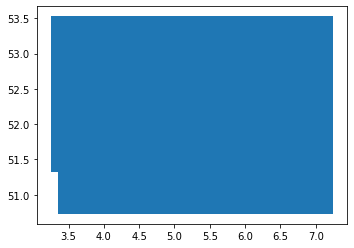

In [16]:
# make sure all files are available
gdf.plot()

In [17]:
# check that there are no more grids to compute
# this should be empty 
gdf[['i', 'j']].sort_values(['i', 'j'])
set(range(40)) - set(gdf['i'])

set()

In [18]:
# convert to usable fields, GEE returns some results in dictionaries
gdf['n_gte0'] = gdf['nGte0'].apply(lambda x: x['elevation'])
gdf['n_lt0'] = gdf['nLt0'].apply(lambda x: x['elevation'])
gdf['total'] = gdf['n_lt0'] + gdf['n_gte0']
gdf['total_count'] = gdf['count'].apply(lambda x: x['elevation'])
gdf['masked_frac'] = gdf['maskedFrac'].apply(lambda x: x['elevation'])

In [19]:
# get the bins and the counts from the histogram
gdf['bins'] = gdf['hist'].apply(lambda x: x['elevation']).apply(lambda x: [x_i[0] for x_i in x] if x else [])
gdf['counts'] = gdf['hist'].apply(lambda x: x['elevation']).apply(lambda x: [x_i[1] for x_i in x] if x else [])

In [20]:
# the % below NAP
gte0 = gdf['n_gte0'].sum() 
lt0 = gdf['n_lt0'].sum()
lt0 / (gte0 + lt0)

0.25933482604812025

In [21]:
# Lookup min and max altitude, the maximum altitude is 83km
# this is an error in the source of AHN2
# there is also a large amount of pixels set to value -5.12, not sure why....
bins = list(itertools.chain.from_iterable(gdf['bins'].values))
counts = list(itertools.chain.from_iterable(gdf['counts'].values))
np.min(bins), np.max(bins), np.min(counts), np.max(counts), bins[np.argmax(counts)]


(-31.29, 83307.52, 0.0, 252703487.65881482, -5.119999999999999)

,geometry,count,hist,maskedFrac,nGte0,nLt0,filename,file_info,i,j,n_gte0,n_lt0,total,total_count,masked_frac,bins,counts,count_x
393,"POLYGON ((4.54654 52.12871, 4.64654 52.12871, ...",{'elevation': 263777984},"{'elevation': [[-15.36, 20158.0], [-10.2399999...",{'elevation': 0.8665202564578398},{'elevation': 7777304.568627451},{'elevation': 256001651.36078432},05m-noclip-13-14ee_export.geojson,"{'i': '13', 'j': '14'}",13,14,7.777305e+06,2.560017e+08,2.637790e+08,263777984,0.866520,"[-15.36, -10.239999999999998, -5.1199999999999...","[20158.0, 3278005.7019607895, 252703487.658814...",2.527035e+08
1099,"POLYGON ((4.44654 51.92871, 4.54654 51.92871, ...",{'elevation': 274587131},"{'elevation': [[-15.41, 1.0], [-15.4, 1.0], [-...",{'elevation': 0.8980162435714634},{'elevation': 8373630.227450982},{'elevation': 266211964.50980392},05m-noclip-12-12ee_export.geojson,"{'i': '12', 'j': '12'}",12,12,8.373630e+06,2.662120e+08,2.745856e+08,274587131,0.898016,"[-15.41, -15.4, -15.39, -15.38, -15.3700000000...","[1.0, 1.0, 3.0, 3.0, 5.0, 8.0, 12.0, 3.0, 9.0,...",1.259554e+06
841,"POLYGON ((4.54654 52.02871, 4.64654 52.02871, ...",{'elevation': 287543767},"{'elevation': [[-13.85, 1.0], [-13.84, 0.0], [...",{'elevation': 0.9424958031048816},{'elevation': 979175.6039215686},{'elevation': 286565912.0549019},05m-noclip-13-13ee_export.geojson,"{'i': '13', 'j': '13'}",13,13,9.791756e+05,2.865659e+08,2.875451e+08,287543767,0.942496,"[-13.85, -13.84, -13.83, -13.82, -13.81, -13.7...","[1.0, 0.0, 1.0, 3.0, 1.0, 0.0, 1.0, 3.0, 1.0, ...",1.095328e+06
111,"POLYGON ((4.54654 52.22871, 4.64654 52.22871, ...",{'elevation': 287703718},"{'elevation': [[-9.03, 1.0], [-9.02, 1.0], [-9...",{'elevation': 0.9472245825598202},{'elevation': 41464503.05882352},{'elevation': 246240272.39215678},05m-noclip-13-15ee_export.geojson,"{'i': '13', 'j': '15'}",13,15,4.146450e+07,2.462403e+08,2.877048e+08,287703718,0.947225,"[-9.03, -9.02, -9.01, -9.0, -8.99, -8.97999999...","[1.0, 1.0, 0.0, 6.0, 8.0, 18.0, 12.0, 4.0, 5.0...",7.868635e+05
465,"POLYGON ((4.64654 52.12871, 4.74654 52.12871, ...",{'elevation': 262003588},"{'elevation': [[-7.42, 1.0], [-7.41, 18.0], [-...",{'elevation': 0.8606972878032394},{'elevation': 4403477.68627451},{'elevation': 257600656.89411747},05m-noclip-14-14ee_export.geojson,"{'i': '14', 'j': '14'}",14,14,4.403478e+06,2.576007e+08,2.620041e+08,262003588,0.860697,"[-7.42, -7.41, -7.4, -7.39, -7.38, -7.37, -7.3...","[1.0, 18.0, 7.0, 3.0, 8.0, 1.0, 0.0, 6.0, 0.0,...",6.743415e+05


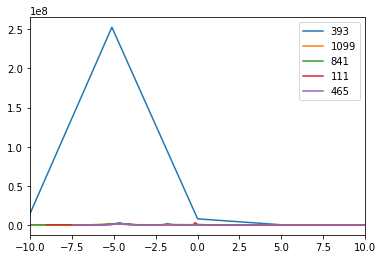

In [22]:
# Lookup the -5.12 pixels, they're all over the place...
# Ah it's because of the histogram of the 83km. All values are now set to -5.12 in that cell. 
# Doesn't affect the output much, because there are only a few cells above 0 in that cell
# Sent a mail to info@ahn.nl, asking them to fix this error
def count_x(row, x=-5.119999999999999):
    if not row['bins']:
        return 0
    if x not in row['bins']:
        return 0
    bins = row['bins']
    idx = bins.index(-5.119999999999999)
    return row['counts'][idx]
gdf['count_x'] = gdf.apply(count_x, axis=1)

fig, ax = plt.subplots()
top_x = gdf.sort_values('count_x', ascending=False).head()
top_x.apply(lambda row: ax.plot(row.bins, row.counts, label=row.name), axis=1)
ax.legend()
ax.set_xlim(-10, 10)
top_x

(-8.0, 100.0)

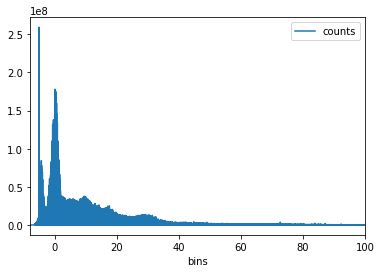

In [23]:
fig, ax = plt.subplots()
hist_df = pd.DataFrame(data=dict(bins=bins, counts=counts))
hist_df = hist_df.groupby('bins').sum()
hist_df = hist_df[hist_df['counts'] > 0]
hist_df.plot(ax=ax)
ax.set_xlim(-8, 100)

In [24]:
gdf['max_bins'] = gdf['bins'].apply(lambda x: np.max(x) if x else 0)

In [25]:
row = gdf.sort_values('max_bins', ascending=False).iloc[:1]

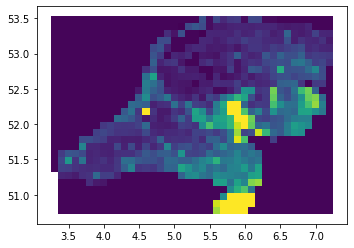

In [26]:
gdf[['geometry', 'max_bins']].plot('max_bins', vmax=100)

In [27]:
# lookup % below sea level
row = gdf.iloc[250]
def perc_count(row, height=0.06):
    idx = np.searchsorted(row['bins'], height)
    count = np.sum(row['counts'][:idx])
    return count
gdf.apply(perc_count, axis=1).sum() / gdf['total'].sum()

0.26695548053518486

In [28]:
# lookup % below sealevel per meter
rows = []
for height in np.linspace(-5, 12.5, num=100):
    perc = gdf.apply(lambda x:perc_count(x, height=height), axis=1).sum() / gdf['total'].sum()
    row = {'height': height, 'perc': perc*100}
    rows.append(row)

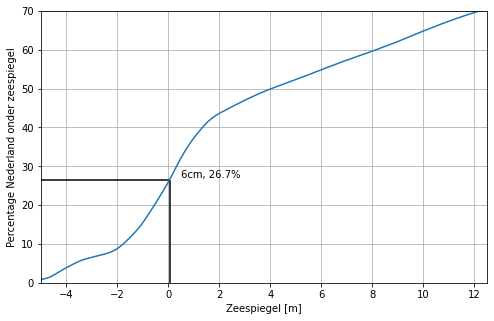

In [29]:
cumulative_df = pd.DataFrame(rows)


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(cumulative_df['height'], cumulative_df['perc'])
ax.set_xlabel('Zeespiegel [m]')
_ = ax.set_ylabel('Percentage Nederland onder zeespiegel')
ax.grid(True)
ax.vlines([0.06], 0, 26.6)
ax.hlines([26.6], -10, 0.06)
ax.annotate('6cm, 26.7%', (0.06, 27), (0.5, 27))
ax.set_ylim(0, 70)
ax.set_xlim(-5, 12.5)
fig.savefig('nl-below-sl.pdf')

In [56]:
ds = cumulative_df.to_xarray()

ds['height'].attrs['units'] = 'meter'
ds['perc'].attrs['long_name'] = 'cumulative percentage of the Netherlands below height'

In [57]:
ds.to_netcdf('./nl-below-sl.nc')

In [58]:
!open .
